# Baselines: Random Noise & raw precip -> SM

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

# Data

In [2]:
run_dir = Path("/datadrive/data/runs/complexity_AZURE/hs_064_0306_205514")

# GET config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

# GET preds
res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)

# GET trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)

100%|██████████| 669/669 [00:00<00:00, 1959.65it/s]


Using the model weights from /datadrive/data/runs/complexity_AZURE/hs_064_0306_205514/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(25, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

### CAMELS GB

In [3]:
from scripts.cell_state.normalize import normalize_xr_by_basin

ds = xr.open_dataset(Path("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc"))
norm_ds = normalize_xr_by_basin(ds)

### Get the cell state data

In [4]:
# from scripts.cell_state.extract_cell_state import get_cell_states
# from scripts.cell_state.normalize import (normalize_xarray_cstate, normalize_xr_by_basin, normalize_cstate)


# data_dir = Path("/datadrive/data/")
# if not (data_dir / "SOIL_MOISTURE/norm_cs_data.nc").exists():
#     out_dir = run_dir / "cell_states"
#     if not out_dir.exists():
#         out_dir.mkdir(parents=True, exist_ok=True)

#     if not (out_dir / "cell_states.nc").exists():
#         cn = get_cell_states(cfg, run_dir)
#         cn.to_netcdf(out_dir / "cell_states.nc")
#     else:
#         cn = xr.open_dataset(out_dir / "cell_states.nc")

#     cs_data = cn.copy()
#     norm_cs_data = normalize_xarray_cstate(cs_data, cell_state_var="c_n")

#     norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
#     if "date" in norm_cs_data.dims:
#         norm_cs_data = norm_cs_data.rename({"date": "time"})
# else:
#     norm_cs_data = xr.open_dataset(data_dir / "SOIL_MOISTURE/norm_cs_data.nc")


# better normalize c state
from scripts.cell_state.normalize import normalize_cstate

data_dir = Path("/datadrive/data")
if not (data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc").exists():
    cn = xr.open_dataset(out_dir / "cell_states.nc")
    norm_cs_data = normalize_cstate(cn, variable_str="c_n")
    norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
    if "date" in norm_cs_data.dims:
        norm_cs_data = norm_cs_data.rename({"date": "time"})

    if isinstance(norm_cs_data, xr.DataArray):
        norm_cs_data = norm_cs_data.to_dataset()

    if "c_n" in [v for v in norm_cs_data.data_vars]:
        norm_cs_data = norm_cs_data.rename({"c_n": "cell_state"})
        
    norm_cs_data.to_netcdf(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
    
else:
    norm_cs_data = xr.open_dataset(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")

### normalised ESA CCI SM

In [5]:
# xr.open_dataset(data_dir / "camels_basin_ESACCI_sm.nc")

In [6]:
# # soil moisture data
# data_dir = Path("/datadrive/data")

# # load in esa cci
# filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
# esa_ds = xr.open_dataset(filepath).drop("spatial_ref")
# esa_ds["station_id"] = esa_ds.station_id.astype("int64")
# esa_ds = esa_ds.sortby("time")

# # normalise sm data
# norm_sm = normalize_xr_by_basin(esa_ds)
# norm_sm["station_id"] = [int(sid) for sid in norm_sm["station_id"]]

In [7]:
from scripts.cell_state.normalize import normalize_2d_dataset

target_filepath = data_dir / "SOIL_MOISTURE/interp_norm_esa_cci_sm.nc"
if not target_filepath.exists():
    interp_filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
    esa_ds = xr.open_dataset(interp_filepath).drop("spatial_ref")

    esa_ds = normalize_2d_dataset(esa_ds)
    esa_ds.to_netcdf(target_filepath)
else:
    esa_ds = xr.open_dataset(target_filepath)

if not isinstance(esa_ds, xr.Dataset):
    esa_ds = esa_ds.to_dataset()
    
norm_sm = esa_ds

#### create X, y samples (timeseries)from typing import Tuple
FOR THE PRECIP EXPERIMENT

In [8]:
from scripts.cell_state.timeseries_dataset import get_matching_dim
from scripts.cell_state.cell_state_dataset import fill_gaps

fill = "interpolate"
target_var = "sm"
input_vars = ["precipitation"]

# matching data
target_time, input_time = get_matching_dim(norm_sm, norm_cs_data, "time")
target_sids, input_sids = get_matching_dim(norm_sm, norm_cs_data, "station_id")

input_data = norm_cs_data.sel(time=input_time, station_id=input_sids)
target_data = norm_sm.sel(time=target_time, station_id=target_sids)

start_date = pd.Timestamp("1998-01-01")
end_date = pd.Timestamp("2008-12-31")

pcp_input_data = norm_ds.sel(time=slice(start_date, end_date))[input_vars]
pcp_input_data = fill_gaps(pcp_input_data, fill="interpolate")

target_data = norm_sm["sm"].sel(time=slice(start_date, end_date))
target_data = fill_gaps(target_data, fill="interpolate")

if not (data_dir / "SOIL_MOISTURE/interpolated_esa_cci_sm.nc").exists:
    target_data.to_netcdf(data_dir / "SOIL_MOISTURE/interpolated_esa_cci_sm.nc")
if not (data_dir / "SOIL_MOISTURE/interpolated_normalised_camels_gb.nc").exists:
    pcp_input_data.to_netcdf(data_dir / "SOIL_MOISTURE/interpolated_normalised_camels_gb.nc")

Filling gaps with method interpolate: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s, precipitation]


# Linear Probe

In [9]:
# from scripts.cell_state.analysis import isfinite_flat, histogram_plot

def isfinite_flat(arr: np.ndarray) -> np.ndarray:
    return arr[np.isfinite(arr)]


def histogram_plot(arr: np.ndarray, ax = None, hist_kwargs = {}):
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 4))
    ax.hist(arr, alpha=0.6, bins=50, density=True, **hist_kwargs);

    # ax2 = ax.twinx()
    # ax2.hist(n, alpha=0.6, bins=50, label="NSE", density=True, color="C1");

    ax.axvline(np.median(arr), ls="--", color="k", alpha=0.8)
    sns.despine()
    ax.set_xlabel("Metric")
    return ax

In [10]:
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable
from scripts.cell_state.timeseries_dataset import get_train_test_dataloader
from scripts.cell_state.cell_state_model import LinearModel
from scripts.cell_state.timeseries_model import train, predict, round_preds_time_to_hour
from scripts.read_nh_results import calculate_all_error_metrics
from scripts.cell_state.analysis import finite_flat, histogram_plot

# convert dimension to variables
cs = dataset_dimensions_to_variable(norm_cs_data, variable="c_n")

In [11]:
batch_size = 1000

og_train_dl, og_test_dl = get_train_test_dataloader(
    input_data=cs,
    target_data=target_data,
    target_variable="sm",
    input_variables=[f"dim{i}" for i in range(64)],
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    batch_size=batch_size,
    train_start_date=pd.to_datetime("01-01-1998"),
    train_end_date=pd.to_datetime("12-31-2006"),
    test_start_date=pd.to_datetime("01-01-2007"),
    test_end_date=pd.to_datetime("01-01-2009"),
    num_workers=4,
)

Creating Test Samples: 100%|██████████| 668/668 [00:04<00:00, 136.47it/s]


In [12]:
# data = og_train_dl.__iter__().__next__()
# for key in [k for k in data.keys() if k != "meta"]:
#     data[key] = data[key].to(device)
# data["x_d"].shape

# import torch 

# y_hat = og_model(data).squeeze()
# y = data["y"].squeeze()
# loss_fn = torch.nn.MSELoss(reduction="sum").to(device)

# loss_fn(y_hat, y)

### initialise and train model

In [45]:
# from datetime import datetime
# now = datetime.now()
# time_now_str = f"{now.day:02}{now.month:02}_{now.hour:02}{now.minute:02}{now.second:02}"
# probe_run_dir = data_dir / "probes/"

In [48]:
import torch 
torch.nn.Linear?

Init signature: torch.nn.Linear(in_features: int, out_features: int, bias: bool = True) -> None
Docstring:     
Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

Args:
    in_features: size of each input sample
    out_features: size of each output sample
    bias: If set to ``False``, the layer will not learn an additive bias.
        Default: ``True``

Shape:
    - Input: :math:`(N, *, H_{in})` where :math:`*` means any number of
      additional dimensions and :math:`H_{in} = \text{in\_features}`
    - Output: :math:`(N, *, H_{out})` where all but the last dimension
      are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

Attributes:
    weight: the learnable weights of the module of shape
        :math:`(\text{out\_features}, \text{in\_features})`. The values are
        initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
        :math:`k = \frac{1}{\text{in\

In [14]:
device = "cuda:0"
D_in = 64

og_model = LinearModel(D_in=D_in)
og_model.to(device)

LinearModel(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

In [17]:
og_losses = train(
    model=og_model,
    dataloader=og_train_dl,
    device=device,
    n_epochs=10
)

Training Model Epoch 9: 100%|██████████| 2196/2196 [00:22<00:00, 97.86it/s, 28.89038]   


In [18]:
# ## save model
# torch.save(model.state_dict(), probe_run_dir)

# ## load model
# og_model = LinearModel(D_in=D_in)
# og_model.load_state_dict(torch.load(probe_run_dir))


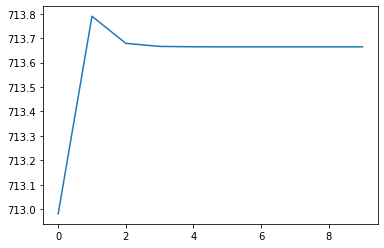

In [19]:
plt.plot(og_losses)

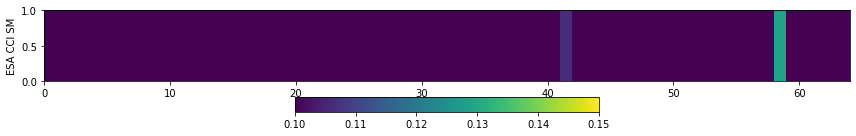

In [20]:
ws, bs = [p.detach().cpu().numpy() for p in og_model.parameters()]

# weights = ws
f, ax = plt.subplots(figsize=(12, 2))
im = ax.pcolormesh(ws, vmin=0.1, vmax=0.15)
ax.set_ylabel(f"ESA CCI SM")

plt.colorbar(im, orientation='horizontal')
plt.tight_layout()

In [21]:
og_preds = predict(model=og_model, dataloader=og_test_dl, device=device)
og_preds = round_preds_time_to_hour(og_preds)

Forward Pass: 100%|██████████| 488/488 [00:06<00:00, 81.06it/s] 


In [22]:
og_preds.to_netcdf(data_dir / "SOIL_MOISTURE/results/linear_probe_preds.nc")

In [23]:
og_errors = calculate_all_error_metrics(
    og_preds,
    basin_coord="station_id",
    time_coord="time",
    obs_var="y",
    sim_var="y_hat",
    metrics=["NSE", "Pearson-r"],
)

(data_dir / "SOIL_MOISTURE/results/linear_probe_control.nc").unlink()
og_errors.to_netcdf(data_dir / "SOIL_MOISTURE/results/linear_probe_control.nc")

Calculating Errors: 100%|██████████| 668/668 [00:07<00:00, 86.91it/s, 106001]


In [24]:
def histogram_plot(arr: np.ndarray, ax = None, hist_kwargs = {}):
    import seaborn as sns 
    import matplotlib.pyplot as plt

    if ax is None:
        _, ax = plt.subplots(figsize=(12, 4))
    ax.hist(arr, alpha=0.6, bins=50, density=True, **hist_kwargs)

    try: 
        color = hist_kwargs["color"]
    except KeyError:
        color = "k"
    ax.axvline(np.median(arr), ls="--", color=color, alpha=0.8)
    sns.despine()
    ax.set_xlabel("Metric")
    return ax


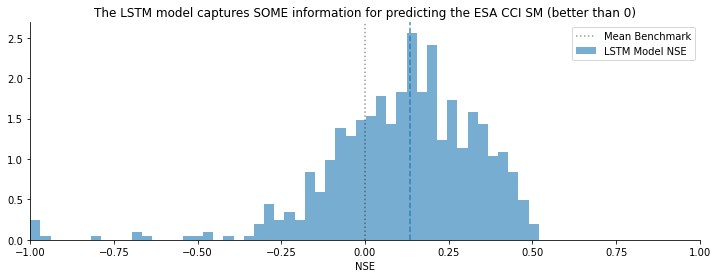

In [25]:
og_r = isfinite_flat(og_errors["Pearson-r"].values)
variable = "NSE"

_, ax = plt.subplots(figsize=(12, 4))
arr = np.clip(isfinite_flat(og_errors[variable].values), -1, 1) if variable == "NSE" else isfinite_flat(og_errors[variable].values)
histogram_plot(arr=arr, ax=ax, hist_kwargs={"color": "C0", "label": f"LSTM Model {variable}"})
ax.axvline(0, ls=":", color="k", alpha=0.4, label="Mean Benchmark")
# histogram_plot(arr=r, ax=ax, hist_kwargs={"color": "C1", "label": "Precip Model"})
ax.set_xlim(-1, 1);
ax.set_xlabel(variable)
ax.set_title("The LSTM probe captures SOME information for predicting the ESA CCI SM (better than 0)")
ax.legend();

In [26]:
# title = f"sum(NSE < -1) = LSTM Data: {(og_n < -1).sum()}" + f" -- Precip Data: {(n < -1).sum()}"

# f, ax = plt.subplots(figsize=(12, 4))
# histogram_plot(arr=og_n[~(og_n < -1)], ax=ax, hist_kwargs={"color": "C0", "label": "NSE LSTM"})
# histogram_plot(arr=n[~(n < -1)], ax=ax, hist_kwargs={"color": "C1", "label": "NSE Precip"})
# ax.set_xlabel("NSE")
# ax.set_title("NSE\n" + title);
# ax.set_xlim(-1, 1)
# plt.legend()

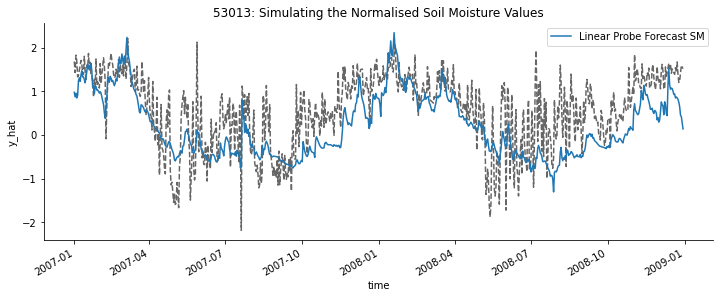

In [27]:
px = np.random.choice(og_preds["station_id"].values)
px = np.random.choice([4003, 52006, 53013, 41003, 15039, 12007, 41019, 53022, 39054])

times = slice("2007", "2008")

f, ax = plt.subplots(figsize=(12, 4))
og_preds.sel(station_id=px)["y"].sel(time=times).plot(ax=ax, color="k", alpha=0.6, ls="--")
og_preds.sel(station_id=px)["y_hat"].sel(time=times).plot(ax=ax, label="Linear Probe Forecast SM", color="C0")
ax.set_title(f"{px}: Simulating the Normalised Soil Moisture Values")
plt.legend()
sns.despine()


### interpretation of cell states

In [28]:
n = 3
largest_n = np.abs(ws.ravel()).argsort()[-n:][::-1]
w_values = np.abs(ws.ravel())[largest_n]
features = [f"dim{idx}" for idx in largest_n]

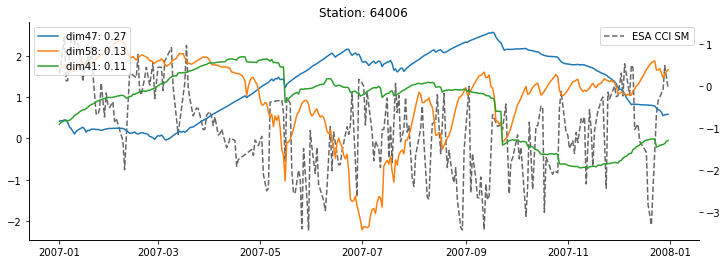

In [29]:
px = np.random.choice(cs.station_id.values)
time = "2007"

sm_data = target_data.to_dataset()["sm"].sel(station_id=px, time=time).to_dataframe()
cs_data = cs.sel(station_id=px, time=time).to_dataframe()

f, ax = plt.subplots(figsize=(12, 4))
ax.plot(sm_data.index, sm_data["sm"], color="k", ls="--", alpha=0.6, label="ESA CCI SM")
ax.legend(loc="upper right")

ax2 = ax.twinx()
for ix, feature in enumerate(features):
    ax2.plot(sm_data.index, cs_data[feature], color=f"C{ix}", label=f"{feature}: {w_values[ix]:.2f}")
    
ax2.legend(loc="upper left")
    
ax.set_title(f"Station: {px}")
sns.despine()

In [30]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [31]:
points = load_latlon_points(Path("/home/tommy/spatio_temporal/data"))
gdf = gpd.GeoDataFrame(og_errors["NSE"].to_dataframe().join(points))

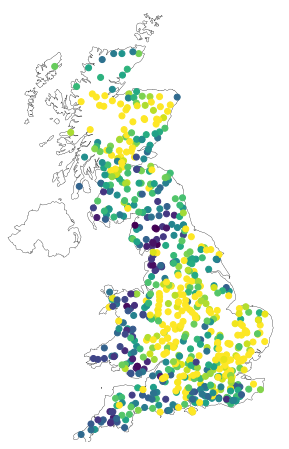

In [32]:
ax = initialise_gb_spatial_plot()

cbar = False
if cbar:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    gdf.plot("NSE", ax=ax, vmin=0, vmax=0.5, cmap="viridis_r", cax=cax, legend=True);
else:
    gdf.plot("NSE", ax=ax, vmin=0, vmax=0.5, cmap="viridis_r")

# Baseline 1: Precip Model

### DataLoader/Dataset

In [33]:
%load_ext autoreload
%autoreload 2

In [34]:
batch_size = 256
train_dl, test_dl = get_train_test_dataloader(
    input_data=pcp_input_data,
    target_data=target_data,
    target_variable="sm",
    input_variables=["precipitation"],
    seq_length=64,
    basin_dim="station_id",
    time_dim="time",
    batch_size=batch_size,
    train_start_date=pd.to_datetime("01-01-1998"),
    train_end_date=pd.to_datetime("12-31-2006"),
    test_start_date=pd.to_datetime("01-01-2007"),
    test_end_date=pd.to_datetime("01-01-2009"),
    num_workers=4,
)

Creating Test Samples: 100%|██████████| 670/670 [00:02<00:00, 315.76it/s]


### train model

In [35]:
D_in = 64
device = "cuda:0"
model = LinearModel(D_in=D_in)
model.to(device)

LinearModel(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

In [36]:
# TRAIN the model
learning_rate = 1e-2
l2_penalty = 1
n_epochs = 10
device = "cuda:0"

losses = train(
    model=model, 
    dataloader=train_dl, 
    learning_rate=learning_rate, 
    l2_penalty=l2_penalty,
    device=device, 
    n_epochs=n_epochs,
)

Training Model Epoch 9: 100%|██████████| 8436/8436 [00:35<00:00, 234.41it/s, 41.99476]  


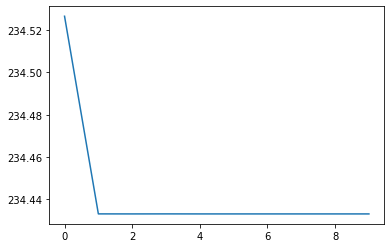

In [37]:
plt.plot(losses)

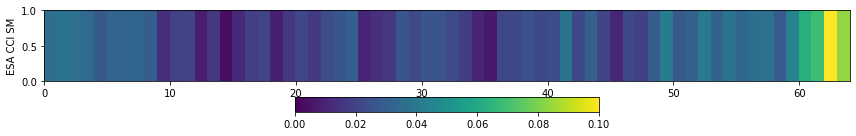

In [38]:
ws, bs = [p.detach().cpu().numpy() for p in model.parameters()]

# weights = ws
f, ax = plt.subplots(figsize=(12, 2))
im = ax.pcolormesh(ws, vmin=0, vmax=0.1)
ax.set_ylabel(f"ESA CCI SM")

plt.colorbar(im, orientation='horizontal')
plt.tight_layout()

# Calculate predictions

In [39]:
#  PREDICT
preds = predict(model=model, dataloader=test_dl, device=device)
preds = round_preds_time_to_hour(preds)


#  EVALUATE with error metrics
errors = calculate_all_error_metrics(
    preds,
    basin_coord="station_id",
    time_coord="time",
    obs_var="y",
    sim_var="y_hat",
    metrics=["NSE", "Pearson-r"],
)
errors.to_netcdf(data_dir / "SOIL_MOISTURE/results/linear_probe_precipitation_sm.nc")

Calculating Errors: 100%|██████████| 670/670 [00:07<00:00, 85.54it/s, 106001]


In [43]:
from scripts.cell_state.analysis import finite_flat, histogram_plot

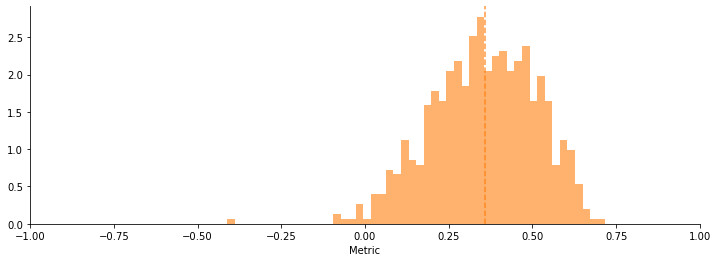

In [44]:
r = finite_flat(errors["Pearson-r"].values)
n = finite_flat(errors["NSE"].values)

f, ax = plt.subplots(figsize=(12, 4))
histogram_plot(arr=r, ax=ax, hist_kwargs={"color": "C1"})
ax.set_xlim(-1, 1)
ax.set_xlabel("Metric");

# Other Time series

In [ ]:
# TODO: AR process ?
# https://towardsdatascience.com/time-series-forecasting-with-autoregressive-processes-ba629717401
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.regression.linear_model import yule_walker

In [ ]:
ar = np.array([1, 0.33, 0.5, 0.2, .15, .1])
ma = np.array([1, 2, 3, 4, 5])

simulated_AR_data = ArmaProcess(ar, ma).generate_sample(nsample=(target_data.shape))
order = len(ar) - 1
print(f"Simulated AR{order} Process")

In [ ]:
ar_target = xr.Dataset(
    {f"ar{order}": (("station_id", "time"), simulated_AR_data)},
    coords={"station_id": target_data.station_id, "time": target_data.time}
)

In [ ]:
choices = np.random.choice(norm_sm.station_id.values, 3)

for px in choices:
    f, ax = plt.subplots(figsize=(12, 4))
    ar_target.sel(station_id=px)[f"ar{order}"].sel(time="2007").plot(ax=ax)
    sns.despine()

In [ ]:
batch_size = 1000

# ORDER (ar process of order n) dataloaders
or_train_dl, or_test_dl = get_train_test_dataloader(
    input_data=cs,
    target_data=ar_target,
    target_variable=f"ar{order}",
    input_variables=[f"dim{i}" for i in range(64)],
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    batch_size=batch_size,
    train_start_date=pd.to_datetime("01-01-1998"),
    train_end_date=pd.to_datetime("12-31-2006"),
    test_start_date=pd.to_datetime("01-01-2007"),
    test_end_date=pd.to_datetime("01-01-2009"),
    num_workers=4,
)

In [ ]:
D_in = 64
or_model = LinearModel(D_in=D_in)
or_model.to(device)

In [ ]:
or_losses = train(
    model=or_model,
    dataloader=or_train_dl,
    device=device,
    n_epochs=10
)

In [ ]:
or_preds = predict(model=or_model, dataloader=or_test_dl, device=device)
og_preds = round_preds_time_to_hour(og_preds)

In [ ]:
or_errors = calculate_all_error_metrics(
    or_preds,
    basin_coord="station_id",
    time_coord="time",
    obs_var="y",
    sim_var="y_hat",
    metrics=["NSE", "Pearson-r"],
)

or_errors.to_netcdf(data_dir / f"SOIL_MOISTURE/results/baseline_AR{order}_process.nc")

In [ ]:
og_r = isfinite_flat(og_errors["Pearson-r"].values)
og_n = isfinite_flat(og_errors["NSE"].values)

or_r = isfinite_flat(or_errors["Pearson-r"].values)
or_n = isfinite_flat(or_errors["NSE"].values)

_, ax = plt.subplots(figsize=(12, 4))
histogram_plot(arr=og_r, ax=ax, hist_kwargs={"color": "C0", "label": "LSTM Model"})
histogram_plot(arr=r, ax=ax, hist_kwargs={"color": "C1", "label": "Precip Model"})
histogram_plot(arr=or_r, ax=ax, hist_kwargs={"color": "C2", "label": "LSTM -- ARMA Process"})
ax.set_xlim(-1, 1);
ax.set_xlabel("Pearson-r")
ax.set_title("The LSTM model better captures the information for predicting the ESA CCI SM than Precip")
ax.legend();

In [ ]:
title = f"sum(NSE < -1) = LSTM Data: {(og_n < -1).sum()}" + f" -- Precip Data: {(n < -1).sum()}" + f" -- ARMA Target: {(or_n < -1).sum()}"

f, ax = plt.subplots(figsize=(12, 4))
histogram_plot(arr=og_n[~(og_n < -1)], ax=ax, hist_kwargs={"color": "C0", "label": "NSE LSTM"})
histogram_plot(arr=n[~(n < -1)], ax=ax, hist_kwargs={"color": "C1", "label": "NSE Precip"})
histogram_plot(arr=or_n[~(or_n < -1)], ax=ax, hist_kwargs={"color": "C2", "label": "NSE Target ARMA"})


ax.set_xlabel("NSE")
ax.set_title("NSE\n" + title);
ax.set_xlim(-1, 1)
ax.set_yscale("log")
ax.set_ylabel("Log Density")
plt.legend();

# Compare sim timeseries

In [ ]:
px = np.random.choice(norm_sm.station_id.values, 1)[0]

times = slice("04-01-2007", "01-01-2008")

f, ax = plt.subplots(figsize=(12, 4))
or_preds = round_preds_time_to_hour(or_preds)
or_preds.sel(station_id=px)["y"].sel(time=times).plot(ax=ax, color="k", alpha=0.6, ls="--")
or_preds.sel(station_id=px)["y_hat"].sel(time=times).plot(ax=ax, label="Random AR Process", color="C2")
ax.set_title(f"{px}: Simulating a Random AR Process")
sns.despine()

    
f, ax = plt.subplots(figsize=(12, 4))
og_preds = round_preds_time_to_hour(og_preds)
og_preds.sel(station_id=px)["y"].sel(time=times).plot(ax=ax, color="k", alpha=0.6, ls="--")
og_preds.sel(station_id=px)["y_hat"].sel(time=times).plot(ax=ax, label="Precip Forecast SM", color="C1")
preds.sel(station_id=px)["y_hat"].sel(time=times).plot(ax=ax, label="LSTM C_t Forecast", color="C0")
ax.set_title(f"{px}: Simulating the Normalised Soil Moisture Values")
plt.legend()
sns.despine()


# f, ax = plt.subplots(figsize=(12, 4))
# preds = round_preds_time_to_hour(preds)
# preds.sel(station_id=px)["y"].sel(time=times).plot(ax=ax, color="k", alpha=0.6, ls="--")
# ax.set_title(f"{px}: Precip Simulation")
# sns.despine()


In [ ]:
test_start_date = pd.to_datetime("01-01-2007")
test_end_date = pd.to_datetime("01-01-2009")


# display(preds.sel(station_id=1001, time="2007"))
# display(og_preds.sel(station_id=1001, time="2007"))

In [ ]:
# pd.date_range(test_start_date, test_end_date)
preds

In [ ]:
# est_times = np.array([t.replace(hour=0, minute=0, second=0, microsecond=0, nanosecond=0) for t in pd.to_datetime(preds.sortby("time").time.values)]
est_times = np.array([t.round('H') for t in pd.to_datetime(preds.sortby("time").time.values)])
pd.date_range(est_times.min(), est_times.max(), freq="D")

In [ ]:
round_preds_time_to_hour(preds).time